# HHLアルゴリズムを用いたポートフォリオ最適化

https://arxiv.org/abs/1811.03975

過去の株価変動のデータから、最適なポートフォリオ（資産配分）を計算する。  
このようなポートフォリオ最適化の問題は、量子計算の基本的なアルゴリズムである「HHLアルゴリズム」を用いることで、従来より高速に解けることが期待されている。  

本ノートブックでは、GAFA(Google, Apple, Facebook, Amazon)の4社の株に投資する際、どのような資産配分を行えば最も低いリスクで高いリターンを得られるかという問題を考える。  

## 株価データ取得

- GAFA 4社の日次データを用いる
- 株価データ取得のためにpandas_datareaderを用いてYahoo! Financeのデータベースから取得
- 株価はドル建ての調整後終値（Adj. Close）を用いる

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# データ取得に必要なpandas_datareaderのインストール
# !pip install pandas_datareader

In [3]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt

In [4]:
# 銘柄選択
codes = ['GOOG', 'AAPL', 'FB', 'AMZN'] # GAFA

# 2017年の1年間のデータを使用
start = datetime.datetime(2017, 1, 1)
end = datetime.datetime(2017, 12, 31)

# Yahoo! Financeから日次の株価データを取得
data = web.DataReader(codes, 'yahoo', start, end)

df = data['Adj Close'] 

display(df.tail())

Symbols,AAPL,AMZN,FB,GOOG
Date,,,,
2017-12-22,171.685074,1168.359985,177.199997,1060.119995
2017-12-26,167.329453,1176.760010,175.990005,1056.739990
2017-12-27,167.358871,1182.260010,177.619995,1049.369995
2017-12-28,167.829758,1186.099976,177.919998,1048.140015
2017-12-29,166.014908,1169.469971,176.460007,1046.400024


#### 株価変動をプロット

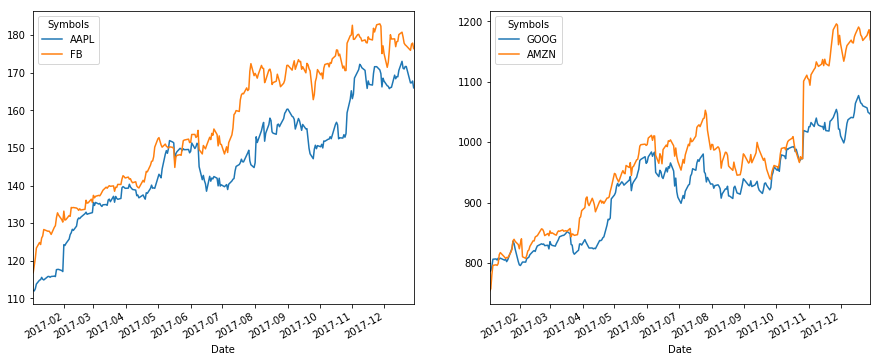

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
df.loc[:,['AAPL', 'FB']].plot(ax=axes[0])
df.loc[:,['GOOG', 'AMZN']].plot(ax=axes[1])

※ここで、4つの銘柄を2つのグループに分けているのは、株価の値がそれぞれ近くプロット時に見やすいからであり、深い意味はない。

## データ前処理

### 株価を日次リターンに

個別銘柄の日次リターン（変化率） $y_t$ （$t$は日付）は以下で定義される。
$$
y_t = \frac{P_t - P_{t-1}}{P_{t-1}}
$$

これはpandas DataFrameのpct_change()メソッドで得られる。

In [6]:
daily_return = df.pct_change()
display(daily_return.tail())

Symbols,AAPL,AMZN,FB,GOOG
Date,,,,
2017-12-22,0.000000,-0.005448,-0.001409,-0.003300
2017-12-26,-0.025370,0.007190,-0.006828,-0.003188
2017-12-27,0.000176,0.004674,0.009262,-0.006974
2017-12-28,0.002814,0.003248,0.001689,-0.001172
2017-12-29,-0.010814,-0.014021,-0.008206,-0.001660


### 期待リターン

銘柄ごとの期待リターン$\vec R$を求める。ここでは過去のリターンの算術平均を用いる：
$$
\vec R = \frac{1}{T} \sum_{t= 1}^{T} \vec y(t)
$$

In [7]:
expected_return = daily_return.dropna(how='all').mean() * 252 # 年率換算のため年間の営業日数252を掛ける
expected_return

Symbols
AAPL    0.411192
AMZN    0.464567
FB      0.430156
GOOG    0.300215
dtype: float64

### 現在価格
各銘柄の現在価格 $\Pi$

In [8]:
current_price = df.iloc[-1].copy()
# current_price.iloc[:] = np.ones(4) # Π=1 のために必要
current_price

Symbols
AAPL     166.014908
AMZN    1169.469971
FB       176.460007
GOOG    1046.400024
Name: 2017-12-29 00:00:00, dtype: float64

In [9]:
df.tail()

Symbols,AAPL,AMZN,FB,GOOG
Date,,,,
2017-12-22,171.685074,1168.359985,177.199997,1060.119995
2017-12-26,167.329453,1176.760010,175.990005,1056.739990
2017-12-27,167.358871,1182.260010,177.619995,1049.369995
2017-12-28,167.829758,1186.099976,177.919998,1048.140015
2017-12-29,166.014908,1169.469971,176.460007,1046.400024


### 分散・共分散行列
リターンの標本不偏分散・共分散行列$\Sigma$は以下で定義される。

$$
\Sigma = \frac{1}{T-1} \sum_{t=1}^{T} ( \vec y(t) -\vec R ) (\vec y(t) -\vec R )^T
$$

In [10]:
cov = daily_return.dropna(how='all').cov() * 252 # 年率換算のため
display(cov)

Symbols,AAPL,AMZN,FB,GOOG
Symbols,,,,
AAPL,0.031119,0.018877,0.016291,0.013303
AMZN,0.018877,0.044120,0.023337,0.021614
FB,0.016291,0.023337,0.028855,0.018382
GOOG,0.013303,0.021614,0.018382,0.023690


## ポートフォリオ最適化

以下の式を満たすようなポートフォリオ（i.e., 資産配分）$\vec w$を求める。

\begin{eqnarray}
&\min_{\vec w}& \vec w^T \Sigma \vec w \\
&{\rm s.t. }& \vec R^T \vec w = \mu \\ 
&&\vec \Pi^T \vec w =\xi
\end{eqnarray}

ここで、3つの式はそれぞれ
- 「ポートフォリオのリターンの分散最小化」
- 「ポートフォリオの期待リターンが$\mu$となること」
- 「ポートフォリオに投資する金額の合計が$\xi$となること」

という条件を表す。


ラグランジュの未定乗数法を用いると、この条件を満たす$\vec w$は、線形方程式

\begin{equation}
W\left ( \begin{array}{c}
\eta \\
\theta \\
\vec w
\end{array}
\right )
=
\left ( \begin{array}{c}
 \mu \\
 \xi \\
\vec 0
\end{array}
\right ),\tag{1}
\end{equation}

$$
\\
W =
\left ( \begin{array}{ccc}
0 & 0 & \vec R^T \\
0 & 0 & \vec \Pi^T \\
\vec{R} &\vec \Pi  & \Sigma
\end{array}
\right ) 
$$

を解くことで得られる事がわかる。ここで$\eta, \theta$はラグランジュの未定乗数法のパラメータ。
$\mu$はポートフォリオの期待リターン、$\xi$は総資産額である。

したがって、最適なポートフォリオ$\vec w$を求めるためには、連立方程式(1)を$\vec w$について解けば良い。

### 行列Wの作成



In [11]:
R = expected_return.values
Pi = current_price.values
S = cov.values

In [12]:
row1 = np.append(np.zeros(2), R).reshape(1,-1)
row2 = np.append(np.zeros(2), Pi).reshape(1,-1)
row3 = np.concatenate([R.reshape(-1,1), Pi.reshape(-1,1), S], axis=1)
W = np.concatenate([row1, row2, row3])

In [13]:
np.set_printoptions(linewidth=200)
print(W)

[[0.00000000e+00 0.00000000e+00 4.11191640e-01 4.64567475e-01 4.30155633e-01 3.00214579e-01]
 [0.00000000e+00 0.00000000e+00 1.66014908e+02 1.16946997e+03 1.76460007e+02 1.04640002e+03]
 [4.11191640e-01 1.66014908e+02 3.11190789e-02 1.88766878e-02 1.62913037e-02 1.33033224e-02]
 [4.64567475e-01 1.16946997e+03 1.88766878e-02 4.41204912e-02 2.33374705e-02 2.16144018e-02]
 [4.30155633e-01 1.76460007e+02 1.62913037e-02 2.33374705e-02 2.88548168e-02 1.83817461e-02]
 [3.00214579e-01 1.04640002e+03 1.33033224e-02 2.16144018e-02 1.83817461e-02 2.36900286e-02]]


### その他のパラメータ

ポートフォリオの期待リターン$\mu$を指定すると、そのようなリターンをもたらす最もリスクの小さいポートフォリオを計算できる。$\mu$は自由に設定できる。一般に期待リターンが大きいほどリスクも大きくなるが、ここでは例として10%としておく。

$\xi$はポートフォリオに投資する合計金額である。ここでは1とおくが、単位は何でも良い。

In [14]:
mu = 0.1 # ポートフォリオのリターン（手で入れるパラメータ）
xi = 1.0 
mu_xi_0 = np.append(np.array([mu, xi]), np.zeros_like(R))
print(mu_xi_0)

[0.1 1.  0.  0.  0.  0. ]


以上で、連立方程式(1)を解く準備が整った。

### 最小分散ポートフォリオ算出

第2章で学んだHHLアルゴリズムを用いて、連立一次方程式(1)を解く。

In [15]:
from HHL import HHL_solve

HHL_solveは、連立方程式Ax=bのA, bを入力として、HHLアルゴリズムを用いて解xを求めるモジュールである。  
引数として上記A, bに加えレジスタ量子ビット数reg_nbit（デフォルト=4）、U=e^{iAt} の位相推定に使う時間t（デフォルト=0.5）を取る。  
返り値は2つあり、それぞれHHLアルゴリズムによる解と、通常の古典計算の対角化による解である。

In [16]:
x_HHL, x_true = HHL_solve(W, mu_xi_0, reg_nbit=8, t=0.5)

A.shape: (6, 6)
b.shape: (6,)
nbit, reg_nbit, t = 3, 8, 0.5


In [17]:
w_opt_HHL = x_HHL[-len(R):] # xから、wのみを取り出す（η, θは不要）
w_opt_true = x_true[-len(R):] # （同上）

In [18]:
w_opt = pd.DataFrame(np.vstack([w_opt_true, w_opt_HHL]).T, index=df.columns, columns=['True', 'HHL'])

In [19]:
w_opt

,True,HHL
Symbols,,
AAPL,0.100909,0.052216
AMZN,0.025267,0.046276
FB,0.157474,0.077905
GOOG,-0.069848,0.002344


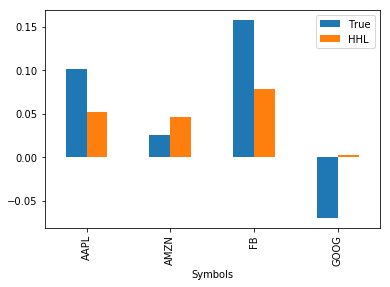

In [20]:
w_opt.plot.bar()

※重みが負になっている銘柄は、「空売り」（株を借りてきて売ること。株価が下がる局面で利益が得られる手法）を表す。

HHLは近似アルゴリズムであるため、古典計算による厳密解と多少乖離がある。  
レジスタ量子ビット数reg_nbitといったパラメータを変化させる等、色々試してみて頂きたい。

## 【Appendix】バックテスト

過去のデータから得られた投資ルールを、それ以降のデータを用いて検証することを「バックテスト」と呼び、その投資ルールの有効性を測るために重要である。

ここでは以上のように2017年のデータから構築したポートフォリオに投資した場合に、翌年の2018年にどの程度資産価値が変化するかを観察する。  

In [21]:
# 2018年の1年間のデータを使用
start = datetime.datetime(2017, 12, 30)
end = datetime.datetime(2018, 12, 31)

# Yahoo! Financeから日次の株価データを取得
data = web.DataReader(codes, 'yahoo', start, end)

df2018 = data['Adj Close'] 

display(df2018.tail())

Symbols,AAPL,AMZN,FB,GOOG
Date,,,,
2018-12-24,146.202972,1343.959961,124.059998,976.219971
2018-12-26,156.498810,1470.900024,134.179993,1039.459961
2018-12-27,155.483154,1461.640015,134.520004,1043.880005
2018-12-28,155.562820,1478.020020,133.199997,1037.079956
2018-12-31,157.066376,1501.969971,131.089996,1035.609985


In [22]:
# ポートフォリオの資産価値の推移
pf_value = df2018.dot(w_opt)

In [23]:
pf_value.head()

,True,HHL
Date,,
2017-12-29,1.000000,78.987688
2018-01-02,1.275554,80.477150
2018-01-03,0.947232,81.472719
2018-01-04,0.835268,81.745831
2018-01-05,0.815392,82.984879


In [24]:
pf_value.HHL = pf_value.HHL / pf_value.HHL[0] # HHLはあくまで近似解で、規格化条件を満たさない場合があるため、期初の値で規格化。

In [25]:
pf_value.head()

,True,HHL
Date,,
2017-12-29,1.000000,1.000000
2018-01-02,1.275554,1.018857
2018-01-03,0.947232,1.031461
2018-01-04,0.835268,1.034919
2018-01-05,0.815392,1.050605


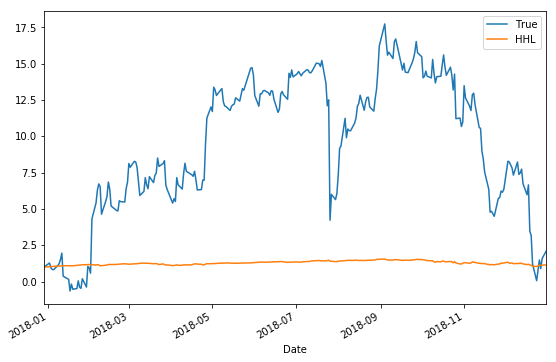

In [26]:
pf_value.plot(figsize=(9, 6))